In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/Shareddrives/Unlimited/Colab/AlphaVision/"
MODEL = "densenet201_aug_rotation_kfold"
model_path = "models_" + MODEL + "/"

In [ ]:
from google.colab import output
# !cp 파일1 파일2 # 파일1을 파일2로 복사 붙여넣기
!cp "/content/drive/Shareddrives/Unlimited/Colab/AlphaVision/AlphaVision.zip" "data_2.zip"
# data_2.zip을 현재 디렉터리에 압축해제
!unzip "data_2.zip"

Archive:  data_2.zip
  inflating: dirty_mnist_2nd.zip     
  inflating: dirty_mnist_2nd_answer.csv  
  inflating: mnist_data.zip          
  inflating: sample_submission.csv   
  inflating: test_dirty_mnist_2nd.zip  


In [ ]:
from google.colab import output
# 현재 디렉터리에 dirty_mnist라는 폴더 생성
!mkdir "./dirty_mnist"
#dirty_mnist.zip라는 zip파일을 dirty_mnist라는 폴더에 압축 풀기
!unzip "dirty_mnist_2nd.zip" -d "./dirty_mnist/"
# 현재 디렉터리에 test_dirty_mnist라는 폴더 생성
!mkdir "./test_dirty_mnist"
#test_dirty_mnist.zip라는 zip파일을 test_dirty_mnist라는 폴더에 압축 풀기
!unzip "test_dirty_mnist_2nd.zip" -d "./test_dirty_mnist/"
# 출력 결과 지우기
output.clear()

In [ ]:
import os
from typing import Tuple, Sequence, Callable
import matplotlib.pyplot as plt
import csv
import cv2
from tqdm import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.optim as optim
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
#from torchinfo import summary

from torchvision import transforms
from torchvision.models import densenet201|

## 1. 커스텀 데이터셋 만들기

In [ ]:
class MnistDataset(Dataset):
    def __init__(
        self,
        dir: os.PathLike,
        image_ids,
        transforms: Sequence[Callable]
    ) -> None:
        self.dir = dir
        self.transforms = transforms
        self.image_ids = image_ids

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, index: int) -> Tuple[Tensor]:
        image_id = self.image_ids.iloc[index, 0]
        image = Image.open(
            os.path.join(
                self.dir, f'{str(image_id).zfill(5)}.png')).convert('RGB')

        target = self.image_ids.iloc[index, 1:].values.astype('float')


        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

## 2. 이미지 어그멘테이션

In [ ]:
transforms_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(90, expand=False),

    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

In [ ]:
dirty_mnist_answer = pd.read_csv("dirty_mnist_2nd_answer.csv")
sample_submission = pd.read_csv("sample_submission.csv")

testset = MnistDataset('test_dirty_mnist', sample_submission, transforms_test)
test_loader = DataLoader(testset, batch_size=32, num_workers=4)

## 3. DenseNet 모형

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Fri Feb 26 11:10:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from torchvision.models import densenet201|
class MnistModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.densenet = densenet201(pretrained=True)
        self.classifier = nn.Linear(1000, 26)

    def forward(self, x):
        x = self.densenet(x)
        x = self.classifier(x)

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MnistModel().to(device)
#print(summary(model, input_size=(1, 3, 256, 256), verbose=0))

## 4. 학습하기

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []
for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer),1):
    # cuda cache 초기화
    torch.cuda.empty_cache()

    #train fold, validation fold 분할
    train_answer = dirty_mnist_answer.iloc[trn_idx]
    valid_answer  = dirty_mnist_answer.iloc[val_idx]

    trainset = MnistDataset('dirty_mnist/', train_answer, transforms_train)
    validset = MnistDataset('dirty_mnist/', valid_answer, transforms_train)
    
    train_loader = DataLoader(trainset, batch_size=32, num_workers=8)
    valid_loader = DataLoader(validset, batch_size=32, num_workers=8)
    
    model = MnistModel().to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.75)
    criterion = nn.MultiLabelSoftMarginLoss()

    num_epochs = 20

    valid_acc_max = 0
    for epoch in range(num_epochs):
        train_acc_list = []
        with tqdm(train_loader, total=train_loader.__len__(), unit="batch") as train_bar:
            for images, labels in train_bar:
              train_bar.set_description(f"Train Epoch {epoch} ")
              optimizer.zero_grad()
              images = images.to(device)
              labels = labels.to(device)

              model.train()
              with torch.set_grad_enabled(True):
                  probs = model(images)
                  loss = criterion(probs, labels)
                  loss.backward()
                  optimizer.step()

                  probs = probs.cpu().detach().numpy()
                  labels = labels.cpu().detach().numpy()
                  preds = probs > 0.5
                  batch_acc = (labels == preds).mean()
                  train_acc_list.append(batch_acc)
                  train_acc = np.mean(train_acc_list)
              
              train_bar.set_postfix(train_loss=loss.item(), train_acc=train_acc)

        valid_acc_list = []
        with tqdm(valid_loader, total=valid_loader.__len__(), unit="batch") as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f"Valid Epoch {epoch}")
                optimizer.zero_grad()
                images = images.to(device)
                labels = labels.to(device)

                model.eval()
                with torch.no_grad():
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                
                valid_acc = np.mean(valid_acc_list)
                valid_bar.set_postfix(valid_loss = valid_loss.item(), valid_acc = valid_acc)

        lr_scheduler.step()

        if valid_acc_max < valid_acc:
            valid_acc_max = valid_acc
            best_model = model
            torch.save(best_model, f'{path + model_path}_{MODEL}_{valid_loss.item():2.4f}_epoch_{epoch}.pth')

    best_models.append(best_model)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


Valid Epoch 19: 100%|██████████| 313/313 [00:44<00:00,  7.05batch/s, valid_acc=0.837, valid_loss=0.39]


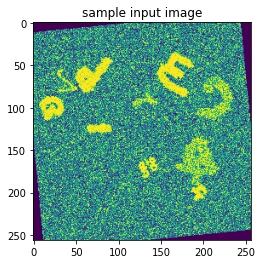

예측값 :  Index(['c', 'g', 'i', 'q', 'r', 'w', 'z'], dtype='object')
정답값 :  Index(['c', 'g', 'i', 'p', 'q', 'r', 't', 'w', 'y', 'z'], dtype='object')


In [ ]:
# gpu에 올라가 있는 tensor -> cpu로 이동 -> numpy array로 변환
sample_images = images.cpu().detach().numpy()
sample_prob = probs#.cpu().detach().numpy()
sample_labels = labels#.cpu().detach().numpy()

idx = 1
plt.imshow(sample_images[idx][0])
plt.title("sample input image")
plt.show()

print('예측값 : ',dirty_mnist_answer.columns[1:][sample_prob[idx] > 0.5])
print('정답값 : ', dirty_mnist_answer.columns[1:][sample_labels[idx] > 0.5])

## 5. 추론하기

In [ ]:
predictions_list = []
prediction_df = pd.read_csv('sample_submission.csv')
batch_size = test_loader.batch_size
batch_index = 0
model = best_models[0]

for model in best_models:
    prediction_array = np.zeros([prediction_df.shape[0],
                                predictino_df.shape[1] -1])
                              
    for i, (images, targets) in enumerate(test_loader):
        model.eval()
        with torch.no_grad():
          images = images.to(device)
          targets = targets.to(device)
          outputs = model(images)
          outputs = outputs > 0.5
          batch_index = i * batch_size
          #submit.iloc[batch_index:batch_index+batch_size, 1:] = \
          #    outputs.long().squeeze(0).detach().cpu().numpy()
          
          prediction_array[batch_index: batch_index + images.shape[0], :] = preds.astype(int)
    predictions_list.append(prediction_array[...,np.newaxis])          
            
#submit.to_csv(path + model_path + "baseline_prediction.csv", index = False)

NameError: ignored

In [ ]:
# axis = 2를 기준으로 평균
predictions_array = np.concatenate(predictions_list, axis = 2)
predictions_mean = predictions_array.mean(axis = 2)

# 평균 값이 0.5보다 클 경우 1 작으면 0
predictions_mean = (predictions_mean > 0.5) * 1
predictions_mean

In [ ]:
# gpu에 올라가 있는 tensor -> cpu로 이동 -> numpy array로 변환
sample_images = images.cpu().detach().numpy()
sample_prob = probs#.cpu().detach().numpy()
sample_labels = labels#.cpu().detach().numpy()

idx = 1
plt.imshow(sample_images[idx][0])
plt.title("sample input image")
plt.show()

print('예측값 : ',dirty_mnist_answer.columns[1:][sample_prob[idx] > 0.5])

In [ ]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.iloc[:,1:] = predictions_mean
sample_submission.to_csv(path + model_path + "baseline_prediction.csv", index = False)
sample_submission

In [ ]:
submit = pd.read_csv('sample_submission.csv')
batch_size = test_loader.batch_size
batch_index = 0
model = torch.load(path+ model_path + '_densenet201_aug_rotation_kfold_0.3056_epoch_17.pth')

for i, (images, targets) in enumerate(test_loader):
    model.eval()
    with torch.no_grad():
      images = images.to(device)
      targets = targets.to(device)
      outputs = model(images)
      outputs = outputs > 0.5
      batch_index = i * batch_size
      submit.iloc[batch_index:batch_index+batch_size, 1:] = \
          outputs.long().squeeze(0).detach().cpu().numpy()
        
submit.to_csv(path + model_path + "baseline_prediction.csv", index = False)